# Completing Bach's famous unfinished fugue
## Linear Regression for time series prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import random
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, log_loss
from scipy import stats
from itertools import islice

# for reproducing
random.seed(2021)

In [2]:
def bar_chart(X, set_X):
    
    notes = []
    freq = []
    for x in set_X:
        notes.append(str(x))
        freq.append(X.count(x))
#         print(f"{x}:\t{X.count(x)}/{len(X)} ~\t{round((X.count(x)/len(X))*100,2)} %")
    
    N = len(set_X)
    ind = np.arange(N) # the x locations for the groups

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])


    ax.bar(ind, freq, 0.75)

    ax.set_ylabel('Freq')
    ax.set_xlabel('Notes')
    ax.set_title('Frequency by note for a voice')
    plt.xticks(ind, set_X)
    steps = 100
    ax.set_yticks(np.arange(0, max(freq)+steps, steps))
    plt.show()

In [3]:
dat = pd.read_csv("F.txt", sep="\t", header=None)
dat

,0,1,2,3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
3819,0,0,49,0
3820,0,0,51,0
3821,0,0,51,0
3822,0,0,54,0


In [4]:
voice = 0 # select voice range (0, 3)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
22 [0, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76]


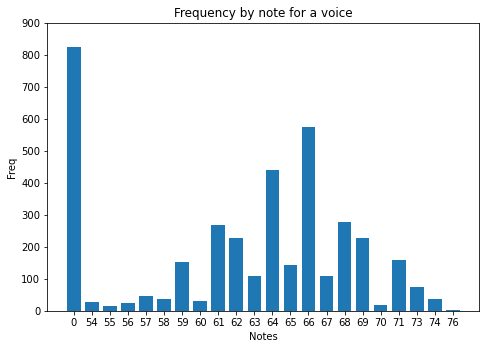

In [5]:
X = list(dat[voice])
print(X[:10])
set_X = list(set(X))
print(len(set_X), set_X)

# frequency per note in the voice
bar_chart(X, set_X)

In [6]:
# get range, mode, mean, probabilities per range for each note in the voice
len_dict = {}
c = 0

for idx, x in enumerate(X):
    if x not in len_dict.keys():
        len_dict[x] = []
    if idx == 0:
        c += 1
    elif x == X[idx-1]:
        c += 1
    else:
        len_dict[X[idx-1]].append(c)
        c = 1
        
for k,v in len_dict.items():
    num = round(np.mean(v))
    if num % 2 != 0:
        num += 1
    d = {}
    for i in v:
        d[i] = round(v.count(i)/len(v), 2)
    len_dict[k] = {"range": v, "mode": stats.mode(v)[0][0], "mean": num, "pd": d}

# example note: 0
print(len_dict[0])

{'range': [248, 16, 96, 62, 16, 180, 128, 8, 4, 32, 6], 'mode': 16, 'mean': 72, 'pd': {248: 0.09, 16: 0.18, 96: 0.09, 62: 0.09, 180: 0.09, 128: 0.09, 8: 0.09, 4: 0.09, 32: 0.09, 6: 0.09}}


[0, 61, 66, 64, 66, 68, 61, 63, 64, 66]


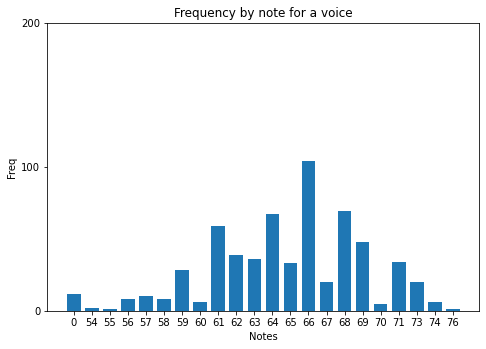

In [7]:
# convert series of notes of length n to 1
X_one = []

for idx, x in enumerate(X):
    if idx == 0:
        X_one.append(x)
    elif x != X[idx-1]:
        X_one.append(x)

print(X_one[:10])
X = X_one

# frequency per note in the voice after transform
bar_chart(X, set_X)

In [8]:
def to_one_hot(set_X, x):
    n = set_X.index(x)
    return [1 if i==n else 0 for i in range(len(set_X))]

In [9]:
# convert to one-hot vector
X_one = [to_one_hot(set_X, x) for x in X]

In [10]:
# Sliding window with one-step forecasting
X_t0 = np.array(X_one[:-1])
y_t1 = np.array(X_one[1:])
print(X_t0[1:3])
print(y_t1[:2])

[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]


In [11]:
reg = LinearRegression().fit(X_t0, y_t1)

In [12]:
# Sanity check on last training instance
reg.predict([X_t0[-1]])[0]

array([ 4.34782609e-02, -4.16333634e-17,  4.16333634e-17,  0.00000000e+00,
       -2.42861287e-17, -1.04083409e-17, -1.11022302e-16, -3.29597460e-17,
        7.24637681e-02,  2.28983499e-16,  4.34782609e-02, -8.32667268e-17,
        1.44927536e-02,  4.49275362e-01,  1.44927536e-02,  1.52655666e-16,
        2.31884058e-01,  2.89855072e-02,  4.34782609e-02,  5.79710145e-02,
        1.38777878e-17,  8.67361738e-19])

In [13]:
# Get the max probability 
# Trace back the note via its index e.g.
yhat = reg.predict([X_t0[49]])
pred = set_X[yhat.tolist()[0].index(max(yhat.tolist()[0]))]
pred

62

Coefficients: 
 [[-0.01786067 -0.01786067 -0.01786067  0.10713933  0.08213933 -0.01786067
   0.01785362 -0.01786067  0.01603764 -0.01786067 -0.01786067 -0.00293529
   0.01244236 -0.00824528 -0.01786067  0.0256176  -0.01786067 -0.01786067
  -0.01786067 -0.01786067 -0.01786067 -0.01786067]
 [-0.05113636 -0.05113636  0.94886364  0.07386364 -0.05113636 -0.05113636
  -0.05113636 -0.05113636 -0.05113636 -0.05113636 -0.05113636 -0.05113636
  -0.05113636 -0.05113636 -0.05113636 -0.05113636 -0.05113636 -0.05113636
  -0.05113636 -0.05113636 -0.05113636 -0.05113636]
 [-0.02272727  0.47727273 -0.02272727 -0.02272727 -0.02272727 -0.02272727
  -0.02272727 -0.02272727 -0.02272727 -0.02272727 -0.02272727 -0.02272727
  -0.02272727 -0.02272727 -0.02272727 -0.02272727 -0.02272727 -0.02272727
  -0.02272727 -0.02272727 -0.02272727 -0.02272727]
 [-0.02310086 -0.02310086 -0.02310086 -0.02310086  0.37689914 -0.02310086
   0.01261342 -0.02310086 -0.00615171 -0.02310086  0.03245469 -0.02310086
  -0.02310086 -0.

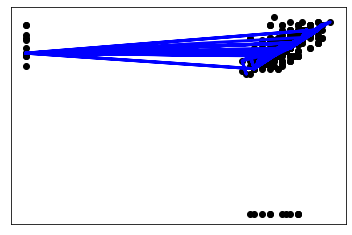

In [14]:
y_pred = [set_X[y.tolist().index(max(y))] for y in reg.predict(X_t0)]
y_test = [set_X[y.tolist().index(max(y))] for y in y_t1]

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X[:-1], y_test,  color='black')
plt.plot(X[:-1], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [16]:
# Cross validation for time series
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X_t0):
    print(f"TRAIN: [{train_index[0]} ... {train_index[-1]}] TEST: [{test_index[0]} ... {test_index[-1]}]")
    X_train, X_test = X_t0[train_index], X_t0[test_index]
    y_train, y_test = y_t1[train_index], y_t1[test_index]

    reg = LinearRegression().fit(X_train, y_train)

    y_pred_vec_train = reg.predict(X_train)
    y_pred_train = [set_X[np.power(_y,3).tolist().index(max(np.power(_y,3)))] for _y in y_pred_vec_train]
    y_train_notes = [set_X[_y.tolist().index(max(_y))] for _y in y_train]
    
    print(f"\t#MSE train\t{round(mean_squared_error(y_train_notes, y_pred_train),2)} "
          f"#train log loss\t{round(log_loss(y_train, y_pred_vec_train),2)} "
          f"#train error\t{round(reg.score(X_train, y_train),2)} "
          f"#train acc\t{round(accuracy_score(y_train_notes, y_pred_train),2)} "
          f"#train f1\t{round(f1_score(y_train_notes, y_pred_train, average='macro'), 2)}")

    y_pred_vec_test = reg.predict(X_test)
    y_pred_test = [set_X[np.power(_y,3).tolist().index(max(np.power(_y,3)))] for _y in y_pred_vec_test]
    y_test_notes = [set_X[_y.tolist().index(max(_y))] for _y in y_test]

    print(f"\t#MSE test\t{round(mean_squared_error(y_test_notes, y_pred_test),2)} "
          f"#test log loss\t{round(log_loss(y_test, y_pred_vec_test),2)} "
          f"#test error\t{round(reg.score(X_test, y_test),2)} "
          f"#test acc\t{round(accuracy_score(y_test_notes, y_pred_test),2)} "
          f"#test f1\t{round(f1_score(y_test_notes, y_pred_test, average='macro'),2)}")

TRAIN: [0 ... 104] TEST: [105 ... 206]
TRAIN: [0 ... 206] TEST: [207 ... 308]
TRAIN: [0 ... 308] TEST: [309 ... 410]
TRAIN: [0 ... 410] TEST: [411 ... 512]
TRAIN: [0 ... 512] TEST: [513 ... 614]


In [18]:
# save the model to disk
filename = f"bach_{voice}.sav"
pickle.dump(reg, open(filename, 'wb'))

In [19]:
# Predict t+1 note n times from t0
preds_vec = np.array([X_t0[-1]])
preds = []
for i in range(100):
    yhat = reg.predict(preds_vec[-1].reshape(1, -1))
    # Pick note, add it
    yhat_dict = dict(zip(set_X, yhat[0].tolist()))
    yhat_dict_sorted = dict(sorted(yhat_dict.items(), key=operator.itemgetter(1),reverse=True))
    top_n = list(islice(yhat_dict_sorted.items(), 10))
    p = random.choice(top_n)[0]
    preds.append(p)
    np.concatenate((preds_vec, [to_one_hot(set_X, p)]))
set(preds), preds[:10]

({0, 61, 63, 65, 66, 67, 69, 70, 71, 73},
 [0, 70, 71, 73, 66, 65, 65, 67, 69, 63])

In [20]:
# Prolong the notes
output = []
for p in preds:
    # Weighted choice (* 2 for longer range of notes)
    range_n = [p] * random.choice(len_dict[p]["range"]) * 2
    output.extend(range_n)
len(output), output[:10]

(1556, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
df = pd.DataFrame(output)
df

,0
0,0
1,0
2,0
3,0
4,0
...,...
1551,73
1552,61
1553,61
1554,61


In [22]:
f = f"F_{voice}.txt"
df.to_csv(f, sep="\t", header=None, index=None)